In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from tqdm.notebook import tqdm
import re
import numpy as np
import datetime as dt
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\donat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\donat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [93]:
#what bbc covers, most covered countries, sentiment analysis (positive news, bad news) ask chatgpt create a dashboard about it
scraper = sntwitter.TwitterProfileScraper('BBCWorld')
# Creating list to append tweet data to
tweets_list = []
n_tweets = 10000
# Using TwitterProfileScraper to scrape data and append tweets to list
for i,tweet in tqdm(enumerate(scraper.get_items()), total=n_tweets):
    if i>n_tweets:
        break
    tweets_list.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])
    
# Creating a dataframe from the tweets list above
df = pd.DataFrame(tweets_list, columns=['Date', 'Tweet Id', 'Text', 'Username'])
df.head()

# Extract only the date component from 'Date' column
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.date

df.to_excel('BBCTweets1404-1706.xlsx', index=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

Skipping unrecognised entry ID: 'profile-conversation-1670188148111441377'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111440382'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111440279'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111440019'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111439823'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111439461'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111439029'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111438992'
Skipping unrecognised entry ID: 'profile-conversation-1670188148111438969'
Stopping after 20 empty pages


In [2]:
df = pd.read_excel('BBCTweets1404-1706.xlsx')


least_recent_tweet = df.sort_values('Date').iloc[0]
print('Least Recent Tweet Date:', least_recent_tweet['Date'])
print('Least Recent Tweet Text:', least_recent_tweet['Text'])
df.shape[0]

Least Recent Tweet Date: 2023-04-14 00:00:00
Least Recent Tweet Text: RT @BBCBreaking: US suspect, 21, accused of leaking secret intelligence documents appears in court a day after his FBI arrest

Follow live…


3234

In [3]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mentions
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # remove URLs
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # remove special characters
    return text

#removing RT for retweets
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\bRT\b', '', x))


df['clean_text'] = df['Text'].apply(clean_text)
df['clean_text'].head()

0    Spain drought forces Fuente de Piedra flamingo...
1    Ukraine war must end South African President R...
2    Hundreds of buildings in western France declar...
3    Police clash with city officials who tried to ...
4    Joe Biden confuses crowd by signing off speech...
Name: clean_text, dtype: object

In [4]:
#Tokenization
df['tokens'] = df['clean_text'].apply(word_tokenize)

#removing stop words
stop_words = set(stopwords.words('english'))
def remove_stop_words(tokens):
    return [token for token in tokens if token.lower() not in stop_words]
df['tokens'] = df['tokens'].apply(remove_stop_words)

#Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    lemmas = []
    for token in tokens:
        pos = get_wordnet_pos(token)
        if pos:
            lemmas.append(lemmatizer.lemmatize(token, pos=pos))
        else:
            lemmas.append(lemmatizer.lemmatize(token))
    return lemmas

def get_wordnet_pos(token):
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

df['lemmas'] = df['tokens'].apply(lemmatize_tokens)


df.head()

,Date,Tweet Id,Text,Username,clean_text,tokens,lemmas
0,2023-06-17,1670156720432135936,Spain drought forces Fuente de Piedra flamingo...,BBCWorld,Spain drought forces Fuente de Piedra flamingo...,"[Spain, drought, forces, Fuente, de, Piedra, f...","[Spain, drought, force, Fuente, de, Piedra, fl..."
1,2023-06-17,1670137483772698880,"Ukraine war must end, South African President ...",BBCWorld,Ukraine war must end South African President R...,"[Ukraine, war, must, end, South, African, Pres...","[Ukraine, war, must, end, South, African, Pres..."
2,2023-06-17,1670114606046490880,Hundreds of buildings in western France declar...,BBCWorld,Hundreds of buildings in western France declar...,"[Hundreds, buildings, western, France, declare...","[Hundreds, building, western, France, declare,..."
3,2023-06-17,1670099129039479040,Police clash with city officials who tried to ...,BBCWorld,Police clash with city officials who tried to ...,"[Police, clash, city, officials, tried, stop, ...","[Police, clash, city, official, try, stop, Sou..."
4,2023-06-17,1670091893844107008,Joe Biden confuses crowd by signing off speech...,BBCWorld,Joe Biden confuses crowd by signing off speech...,"[Joe, Biden, confuses, crowd, signing, speech,...","[Joe, Biden, confuses, crowd, signing, speech,..."


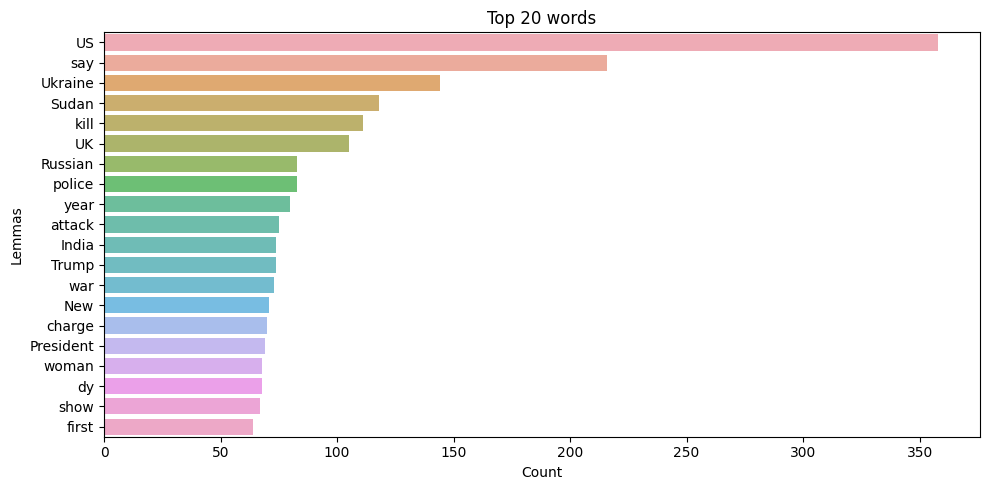

In [5]:
from collections import Counter

# Flatten the list of lemmatized tokens
lemmas_flat = [lemma for sublist in df['lemmas'] for lemma in sublist]


lemma_counts = Counter(lemmas_flat)
top_lemmas = lemma_counts.most_common(20)

# Create a DataFrame for the top lemmas
top_lemmas = pd.DataFrame(top_lemmas, columns=['Lemma', 'Count'])

# Plot the top words
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Lemma', data=top_lemmas, alpha=0.8)
plt.xlabel('Count')
plt.ylabel('Lemmas')
plt.title('Top 20 words')
plt.tight_layout()
plt.show()

# Clustering words

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate the lemmas back into sentences
sentences = [' '.join(lemmas) for lemmas in df['lemmas']]
df['sentences'] = sentences

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(sentences)

# Get the feature names (terms)
feature_names = vectorizer.get_feature_names_out()

# Find the average TF-IDF score for each term
avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]

# Create a dataframe with terms and their average TF-IDF scores
terms_df = pd.DataFrame({'Term': feature_names, 'TF-IDF Score': avg_tfidf_scores})

# Sort the dataframe by TF-IDF scores in descending order
sorted_terms_df = terms_df.sort_values('TF-IDF Score', ascending=False)

# Display the top terms with their TF-IDF scores
top_terms = sorted_terms_df.head(10)  # Adjust the number as per your requirement
print(top_terms)

         Term  TF-IDF Score
5965       us      0.019581
4941      say      0.012865
5877  ukraine      0.010666
5444    sudan      0.009520
3937      new      0.008904
3257     kill      0.008342
4347   police      0.008072
5876       uk      0.007716
3549      man      0.007155
6098      war      0.006888


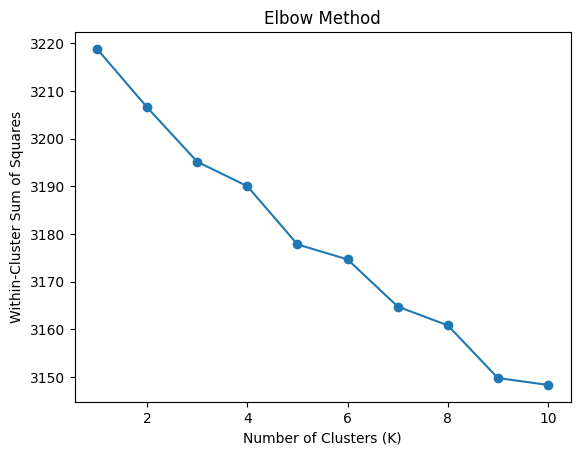

In [7]:
from sklearn.cluster import KMeans

# Instantiate the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text data to obtain the bag-of-words matrix
bow_matrix = vectorizer.fit_transform(sentences)

#Elbow Method
# list to store the within-cluster sum of squares (WCSS)
wcss = []

# Define the range of K values to try
k_values = range(1, 11)

# Compute WCSS for each K
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(bow_matrix)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.show()

In [8]:
# Set the optimal number of clusters (K)
num_clusters = 9

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(bow_matrix)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Display the resulting dataframe with cluster labels
print(df[['lemmas', 'Cluster']])

                                                 lemmas  Cluster
0     [Spain, drought, force, Fuente, de, Piedra, fl...        6
1     [Ukraine, war, must, end, South, African, Pres...        7
2     [Hundreds, building, western, France, declare,...        0
3     [Police, clash, city, official, try, stop, Sou...        0
4     [Joe, Biden, confuses, crowd, signing, speech,...        0
...                                                 ...      ...
3229                           [Austria, medium, guide]        0
3230                   [damage, US, intelligence, leak]        2
3231  [Tibetan, leader, defends, Dalai, Lamas, reque...        0
3232  [Rare, giant, anteater, birth, boost, specie, ...        0
3233  [US, suspect, 21, accuse, leak, secret, intell...        3

[3234 rows x 2 columns]


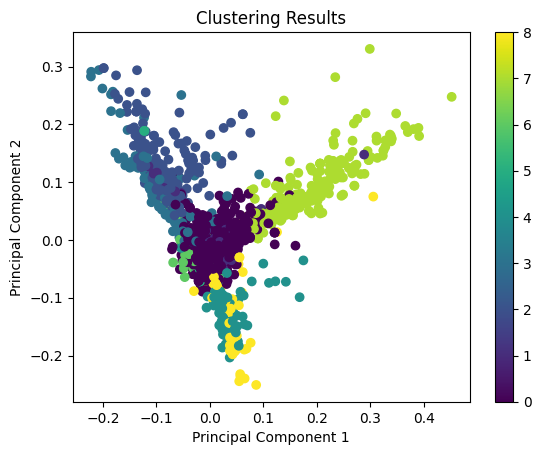

In [9]:
from sklearn.decomposition import PCA

# Perform dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bow_matrix.toarray())

# Create a scatter plot of the data points colored by cluster labels
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [10]:
# Fit K-means clustering on the bag-of-words matrix
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(bow_matrix)

# Get the centroid vectors
centroids = kmeans.cluster_centers_

# Get the feature names from the TfidfVectorizer
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each cluster
for i, centroid in enumerate(centroids):
    cluster_words = [feature_names[ind] for ind in centroid.argsort()[:-11:-1]]  # Get the top 10 words
    print(f"Cluster {i}: {', '.join(cluster_words)}")


Cluster 0: say, police, india, uk, man, dy, woman, year, eurovision, arrest
Cluster 1: shoot, kill, texas, gunman, mall, school, alabama, dead, palestinian, israeli
Cluster 2: us, debt, ceiling, biden, first, deal, joe, say, two, found
Cluster 3: trump, court, donald, supreme, document, jean, trumps, classify, charge, former
Cluster 4: sudan, khartoum, ceasefire, conflict, evacuation, uk, gunfire, evacuate, flee, crisis
Cluster 5: king, coronation, charles, royal, camilla, iii, queen, william, prince, charless
Cluster 6: new, york, zealand, fire, subway, hostel, child, law, president, elon
Cluster 7: ukraine, russian, war, russia, ukrainian, dam, say, kyiv, attack, missile
Cluster 8: fight, sudan, sudans, khartoum, continue, residents, capital, general, evacuate, country


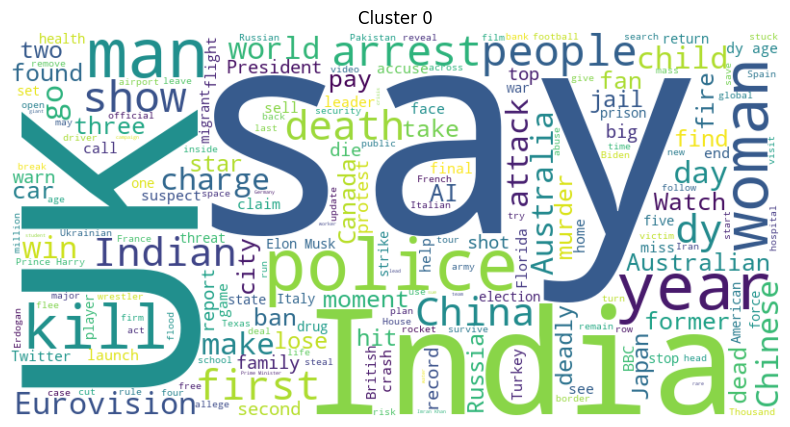

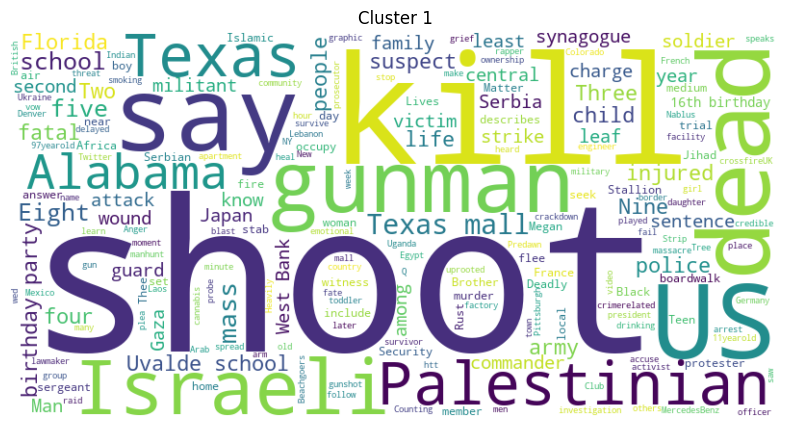

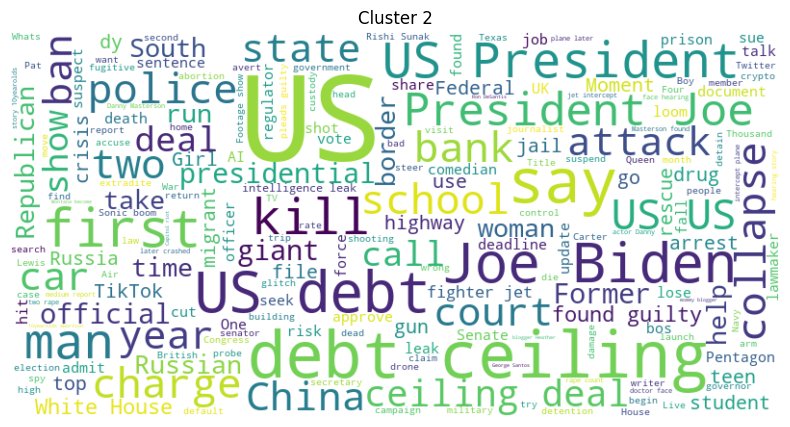

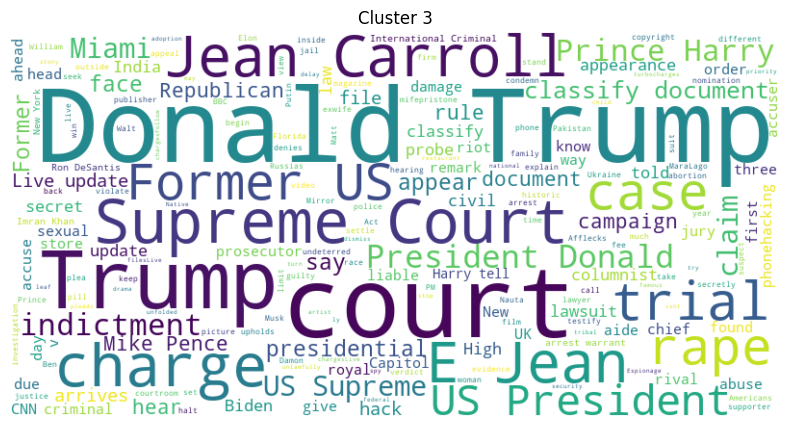

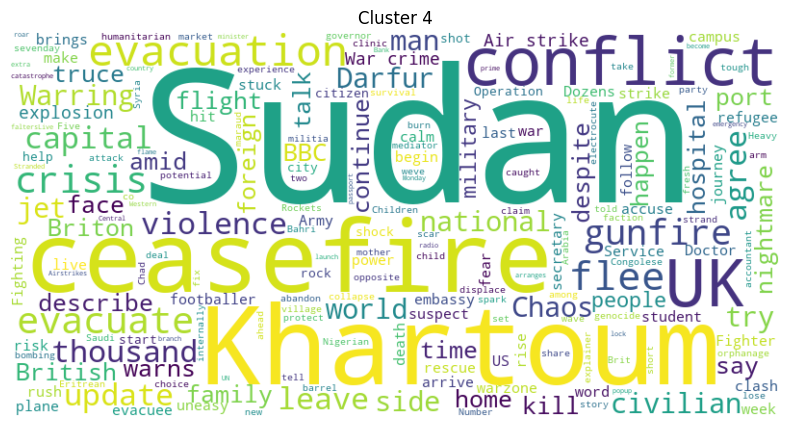

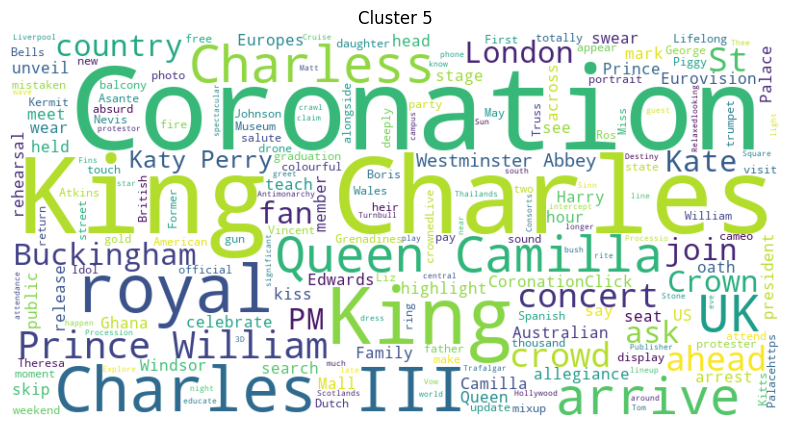

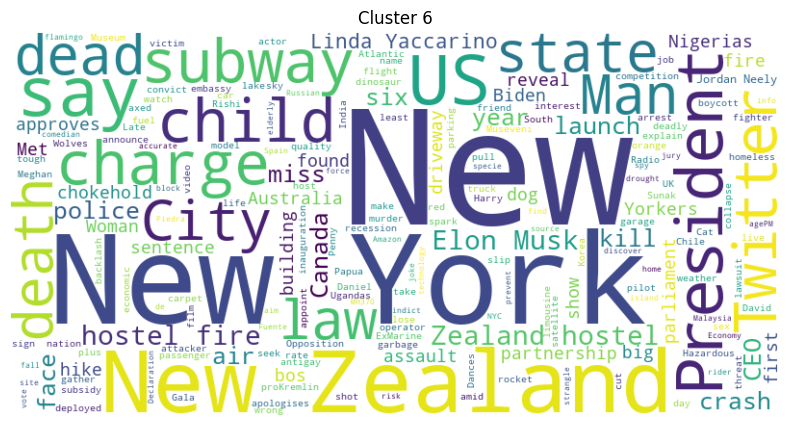

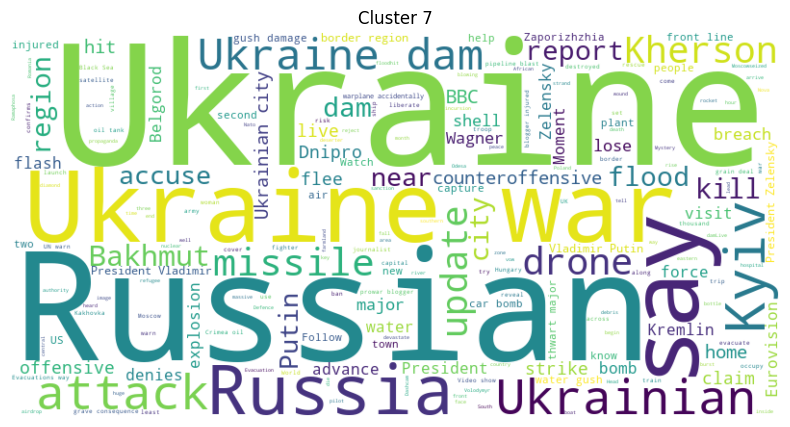

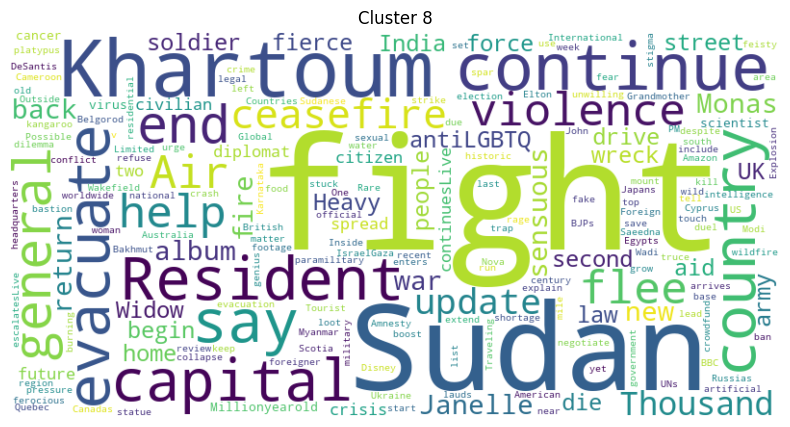

In [106]:
from wordcloud import WordCloud

# Aggregate text data for each cluster
cluster_text = [' '.join(df['sentences'][cluster_labels == i]) for i in range(num_clusters)]

# Generate word clouds for each cluster
for i in range(num_clusters):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text[i])
    
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Cluster {i}')
plt.axis('off')
plt.show()

# Tweets Classification using Logistic Regression

In [12]:
df['Category'] = ''
#df_BBCsampletotrain = df.sample(frac=0.2, random_state=42)

# Export the training set to an Excel file
#df_BBCsampletotrain.to_excel('df_BBCsampletotrain.xlsx', index=False)

# Manually assign the categories to the tweets in the "df_BBCsampletotrain" file using Excel

# Load the categorized training set back into a DataFrame
sample_df = pd.read_excel('df_BBCsampletotrain.xlsx')

In [13]:
tweets_with_categories = sample_df["Text"].tolist()
df_nocat = df[~df["Text"].isin(tweets_with_categories)]
df_nocat.shape

(2587, 10)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Combine both datasets to create the training set
df = pd.concat([sample_df, df_nocat], axis=0, ignore_index=True)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["sentences"])

# Separate the training data and the data without categories
X_train = X[:len(sample_df)]
X_predict = X[len(sample_df):]

# Train the model
y_train = sample_df["Category"]

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict categories
predicted_categories = model.predict(X_predict)

# Assign categories to tweets without categories
df_nocat["Category"] = predicted_categories

# Print the assigned categories
df_nocat["Category"].value_counts()
df = pd.concat([sample_df, df_nocat], axis=0, ignore_index=True)
df['Category'].value_counts()

Category
Entertainment, Culture and Society    1288
Crime                                  756
Politics                               518
Russia-Ukraine War                     232
Economics, Business and Technology     214
Natural Disasters and Tragedies        106
Sudan War                               84
Miscellaneous                           36
Name: count, dtype: int64

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Accuracy
y_true = sample_df["Category"]  # True categories from the sample_df
y_pred = model.predict(X_train)  # Predicted categories from the model
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Classification report
classification_rep = classification_report(y_true, y_pred)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.9242658423493045
Confusion Matrix:
[[128   0   0   0   0   0   0   0]
 [  1  82   0   0   0   0   0   0]
 [  2   0 132   0   0   0   0   0]
 [ 14   0  19   1   0   2   0   0]
 [  1   0   3   0  56   0   0   0]
 [  0   0   1   0   0 108   0   0]
 [  1   0   2   0   0   0  62   0]
 [  0   0   3   0   0   0   0  29]]
Classification Report:
                                    precision    recall  f1-score   support

                             Crime       0.87      1.00      0.93       128
Economics, Business and Technology       1.00      0.99      0.99        83
Entertainment, Culture and Society       0.82      0.99      0.90       134
                     Miscellaneous       1.00      0.03      0.05        36
   Natural Disasters and Tragedies       1.00      0.93      0.97        60
                          Politics       0.98      0.99      0.99       109
                Russia-Ukraine War       1.00      0.95      0.98        65
                         Sudan War      

In [18]:
# Predict probabilities for each category
prob_predictions = model.predict_proba(X_predict)

class_labels = model.classes_

# Create a DataFrame to store the results
prob_df = pd.DataFrame(prob_predictions, columns=class_labels)

# Add the tweet text from df_without_categories
prob_df["Tweet"] = df_nocat["Text"].values

# Print the resulting DataFrame
print(prob_df)

         Crime  Economics, Business and Technology  \
0     0.219872                            0.124947   
1     0.134254                            0.103821   
2     0.140469                            0.107354   
3     0.201500                            0.115344   
4     0.342917                            0.091658   
...        ...                                 ...   
2582  0.192385                            0.132759   
2583  0.135813                            0.413758   
2584  0.217406                            0.122394   
2585  0.166000                            0.139500   
2586  0.130170                            0.175489   

      Entertainment, Culture and Society  Miscellaneous  \
0                               0.201876       0.055826   
1                               0.131955       0.043815   
2                               0.228671       0.059170   
3                               0.272157       0.062749   
4                               0.102711       0.057388 

In [19]:
nlp = spacy.load("en_core_web_sm")

tweets = df["sentences"].tolist()

# Identify the related country for each tweet
countries = []

for tweet in tweets:
    doc = nlp(tweet)
    country = None
    for ent in doc.ents:
        if ent.label_ == "GPE":  # GPE represents geopolitical entity
            country = ent.text
            break
    countries.append(country)

df["Country"] = countries

not_countries=['Eyewitnesses', 'Sanda', 'Man City', 'BP', 'DR', 'F1', 'Europes', 'Holes', 'Stripper', 'BBCEurovision', 'Bidens',
               'Binance', 'Cop City', 'First Republic', 'Holes', 'Holy Fire', 'Foxconn', 'LinkedIn', 'Leyen', 'El Galen', 
              'meme', 'Ludhiana', 'Moonbin', 'Odisha', 'Wakefield', 'Wildfire', 'transphobia', 'Transgender', 'Tracing', 
               'Singersongwriter', 'Sia', 'Scale', 'Russophobia', 'OpenAI', 'Olivia', 'Old City', 'Pearl Beach', 'Nablus'
              'Netflix', 'Neeva', 'Nirvana']

for country in not_countries:
    df['Country'] = df['Country'].str.replace(country, '')


# Print the updated DataFrame
df['Country'].value_counts()

Country
US              282
Ukraine         104
UK               90
Sudan            88
India            59
               ... 
Washington        1
Salford           1
Zaporizhzhia      1
South Dakota      1
Austria           1
Name: count, Length: 235, dtype: int64

In [20]:
# List of values to replace
replace_dict = {
    'Afghanistan': 'Afghanistan',
    'Alabama': 'US',
    'Alaska': 'US',
    'Albania': 'Albania',
    'Alberta': 'Canada',
    'America': 'US',
    'Amsterdam': 'Netherlands',
    'Annecy': 'France',
    'Arabia': 'Saudi Arabia',
    'Argentina': 'Argentina',
    'Arizona': 'US',
    'Asteroid City': 'US',
    'Atlanta': 'US',
    'Australia': 'Australia',
    'Austria': 'Austria',
    'Bangladesh': 'Bangladesh',
    'Bangladesh Myanmar': 'Bangladesh',
    'Barcelona': 'Spain',
    'Beijing': 'China',
    'Belarus': 'Belarus',
    'Belfast': 'UK',
    'Belgorod': 'Russia',
    'Belgrade': 'Serbia',
    'Boston': 'US',
    'Botswana': 'Botswana',
    'Brazil': 'Brazil',
    'Britain': 'UK',
    'Brussels': 'Belgium',
    'Bulgari': 'Bulgaria',
    'Cairo': 'Egypt',
    'California': 'US',
    'Cambodia': 'Cambodia',
    'Canada': 'Canada',
    'Canterbury': 'UK',
    'Catalonia': 'Spain',
    'Chad': 'Chad',
    'Chicago': 'US',
    'Chile': 'Chile',
    'China': 'China',
    'Colombia': 'Colombia',
    'Colorado': 'US',
    'Congo': 'Congo',
    'Connecticut': 'US',
    'Cornwall': 'UK',
    'Crimean': 'Ukraine',
    'Croatia': 'Croatia',
    'Cuba': 'Cuba',
    'Dallas': 'US',
    'Darfur': 'Sudan',
    'Delhi': 'India',
    'Delhi city': 'India',
    'Democratic Republic Congo': 'Democratic Republic Congo',
    'Denmark': 'Denmark',
    'Denver': 'US',
    'Dominican Republic': 'Dominican Republic',
    'Dresden': 'Germany',
    'Dubai': 'United Arab Emirates',
    'Dublin': 'Ireland',
    'Egypt': 'Egypt',
    'El Paso': 'US',
    'El Salvador': 'El Salvador',
    'England': 'UK',
    'Erdogan': 'Turkey',
    'Ethiopia': 'Ethiopia',
    'Florida': 'US',
    'Floridas': 'US',
    'France': 'France',
    'Gambia': 'Gambia',
    'Gaza': 'Palestine',
    'Gaza Strip': 'Palestine',
    'Georgia': 'Georgia',
    'Germany': 'Germany',
    'Germanys': 'Germany',
    'Ghana': 'Ghana',
    'Greece': 'Greece',
    'Guam': 'Guam',
    'Haiti': 'Haiti',
    'Hollywood': 'US',
    'Honduras': 'Honduras',
    'Hong Kong': 'Hong Kong',
    'Hungary': 'Hungary',
    'Idaho': 'US',
    'Illinois': 'US',
    'India': 'India',
    'India Africa': 'India',
    'Indiamade': 'India',
    'Iowa': 'US',
    'Iran': 'Iran',
    'Iraq': 'Iraq',
    'Ireland': 'Ireland',
    'Israel': 'Israel',
    'Istanbul': 'Turkey',
    'Italy': 'Italy',
    'Japan': 'Japan',
    'Jerusalem': 'Israel',
    'Kabul': 'Afghanistan',
    'Kansas City': 'US',
    'Karnataka': 'India',
    'Kaveri': 'India',
    'Kentucky': 'US',
    'Kenya': 'Kenya',
    'Kerala': 'India',
    'Khartoum': 'Sudan',
    'Kherson': 'Ukraine',
    'Kolkata': 'India',
    'Kosovo': 'Kosovo',
    'Kpop': 'South Korea',
    'Kyiv Ukraine': 'Ukraine',
    'Laos': 'Laos',
    'Latvia': 'Latvia',
    'Lebanon': 'Lebanon',
    'Leipzig': 'Germany',
    'London': 'UK',
    'Los Angeles': 'US',
    'Los Choneros': 'Ecuador',
    'Louisiana': 'US',
    'Macau': 'Macau',
    'Madrid': 'Spain',
    'Malaysia': 'Malaysia',
    'Manchester City': 'UK',
    'Marseille': 'France',
    'Melbourne': 'Australia',
    'Mexico': 'Mexico',
    'Miami': 'US',
    'Michigan': 'US',
    'Milan': 'Italy',
    'Minneapolis': 'US',
    'Mississippi': 'US',
    'Missouri': 'US',
    'Mogadishu': 'Somalia',
    'Moldovan': 'Moldova',
    'Montana': 'US',
    'Morocco': 'Morocco',
    'Moscow': 'Russia',
    'Mumbai': 'India',
    'Myanmar': 'Myanmar',
    'Mystery Virginia': 'US',
    'Napoli': 'Italy',
    'Nepal': 'Nepal',
    'Netherlands': 'Netherlands',
    'New Guinea': 'New Guinea',
    'New Mexico': 'US',
    'New York': 'US',
    'New York City': 'US',
    'New Zealand': 'New Zealand',
    'New Zealand Economy slip': 'New Zealand',
    'New Zealands': 'New Zealand',
    'Nigeria': 'Nigeria',
    'North Carolina': 'US',
    'North Indian': 'India',
    'North Korea': 'North Korea',
    'Northern Ireland': 'UK',
    'Norway': 'Norway',
    'NZ': 'New Zealand',
    'Ohio': 'US',
    'Oklahoma': 'US',
    'Pakistan': 'Pakistan',
    'Palau': 'Palau',
    'Paris': 'France',
    'Peru': 'Peru',
    'Philadelphia': 'US',
    'Pittsburgh': 'US',
    'Poland': 'Poland',
    'Portland': 'US',
    'Portugal': 'Portugal',
    'Prince Louis': 'UK',
    'Puntland': 'Somalia',
    'Qatar': 'Qatar',
    'Quebec': 'Canada',
    'Republic Ireland': 'Ireland',
    'RioParis': 'France',
    'Romania': 'Romania',
    'Rome': 'Italy',
    'Row Germany': 'Germany',
    'Russia': 'Russia',
    'Rwanda': 'Rwanda',
    'Salford': 'UK',
    'Sanaa': 'Yemen',
    'Saudi Arabia': 'Saudi Arabia',
    'Scotland': 'UK',
    'Seoul': 'South Korea',
    'Serbia': 'Serbia',
    'Sicily': 'Italy',
    'Singapore': 'Singapore',
    'Somalia': 'Somalia',
    'South Africa': 'South Africa',
    'South Africas': 'South Africa',
    'South Carolina': 'US',
    'South Dakota': 'US',
    'South Korea': 'South Korea',
    'South Sudan': 'South Sudan',
    'Spain': 'Spain',
    'Sri Lanka': 'Sri Lanka',
    'Sudan': 'Sudan',
    'Sudan village': 'Sudan',
    'Sweden': 'Sweden',
    'Switzerland': 'Switzerland',
    'Sydney': 'Australia',
    'Syria': 'Syria',
    'Taiwan': 'Taiwan',
    'Texas': 'US',
    'Thailand': 'Thailand',
    'Tibet': 'Tibet',
    'Tokyo': 'Japan',
    'Toronto': 'Canada',
    'Tunisia': 'Tunisia',
    'Turkey': 'Turkey',
    'Turkeys': 'Turkey',
    'Uganda': 'Uganda',
    'UK': 'UK',
    'Ukraine': 'Ukraine',
    'Ukraine 1200mile': 'Ukraine',
    'Ukraine Kremlin': 'Ukraine',
    'Ukraine Northern Ireland': 'Ukraine',
    'Ukrainian': 'Ukraine',
    'United States': 'US',
    'US': 'US',
    'USA': 'US',
    'Utah': 'US',
    'Venice': 'Italy',
    'Vietnam': 'Vietnam',
    'Virginia': 'US',
    'Wales': 'UK',
    'Washington': 'US',
    'Washington DC': 'US',
    'West Bank': 'Palestine',
    'West Ham': 'UK',
    'Yemen': 'Yemen',
    'Yunnan': 'China',
    'Zaporizhzhia': 'Ukraine',
    'Zelenksy': 'Ukraine',
    'Zimbabwe': 'Zimbabwe',
    'Nablus': '',
    'Netflix': ''
}

df['Country'] = df['Country'].replace(replace_dict)
df['Country'].value_counts()

Country
US         489
UK         119
Ukraine    119
Sudan      110
India       70
          ... 
Georgia      1
Romania      1
Iraq         1
Palau        1
Austria      1
Name: count, Length: 100, dtype: int64

In [30]:
df.to_excel('df_BBCtweets.xlsx', index=False)

In [25]:
word_list = df[['Date', 'Category', 'sentences']].explode('sentences')
word_list['Words'] = word_list['sentences'].str.split()

word_list = word_list.explode('Words').reset_index(drop=True)
word_list = word_list[['Date', 'Category', 'Words']]

word_list.to_excel('BBCtweets_wordlist.xlsx', index=False)